Step 1 크롤링 : 카카오맵 리뷰 크롤링

In [2]:
#-*- coding : utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time

import warnings
warnings.filterwarnings("ignore")

In [4]:
# ChromeDriver auto install method
from webdriver_manager.chrome import ChromeDriverManager
# for not defined By
from selenium.webdriver.common.by import By

executable_path = ChromeDriverManager().install()
url = "https://map.kakao.com/"

driver = webdriver.Chrome(executable_path)
driver.get(url)

searchbox = driver.find_element(By.XPATH, "//input[@id='search.keyword.query']")
searchbox.send_keys("고깃집")

searchbutton = driver.find_element(By.XPATH, "//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)

time.sleep(2)

html = driver.page_source

soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)
    
driver.close()

https://place.map.kakao.com/1720612210
https://place.map.kakao.com/1210249885
https://place.map.kakao.com/285402441
https://place.map.kakao.com/10674476
https://place.map.kakao.com/27401255
https://place.map.kakao.com/11975911
https://place.map.kakao.com/146201851
https://place.map.kakao.com/7865887
https://place.map.kakao.com/487116221
https://place.map.kakao.com/12502209
https://place.map.kakao.com/27496691
https://place.map.kakao.com/12990847
https://place.map.kakao.com/27338280
https://place.map.kakao.com/762032344
https://place.map.kakao.com/1160606492


In [5]:
columns = ["score", "review"]
df = pd.DataFrame(columns=columns)

executable_path = ChromeDriverManager().install()
driver = webdriver.Chrome(executable_path)

for page_url in page_urls:
    
    # 상세보기 페이지에 접속
    driver.get(page_url)
    time.sleep(2)

    # 첫 페이지 리뷰 크롤링
    html = driver.page_source
    source = BeautifulSoup(html, "html.parser")
    
    try:
        contents_div = soup.find(name="div", attrs={"class":"cont_evaluation"})

        # 별점 가져오기
        rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})

        # 리뷰 가져오기
        reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment_txt_fold"})
    
    except:
        continue
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find("span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    # total_num.text : 전체 등록된 리뷰의 건수
    page_num = int(total_num.text) // 5 + 1
    for button_num in range(2, page_num + 1):
        
        try:
            another_reviews = driver.find_element(By.XPATH, "//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)

            # 페이지 리뷰를 크롤링
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")

            contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})
        
            # 별점 가져오기
            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})
            
            # 리뷰 가져오기
            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})
            
            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        
        # 오류가 나는 경우(리뷰 페이지가 없는 경우), 수행하지 않기        
        except:
            continue

driver.close()

df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head()

(0, 3)


,score,review,y


Step 2 텍스트 전처리 : 분류 모델 피처로 변환하기

In [4]:
data = pd.read_csv('./review_data.csv')
data.head()

,score,review,y
0,5,新鮮でおいしいです。,1
1,4,녹는다 녹아,1
2,4,좋아요,1
3,5,흠잡을곳 없는 반찬이 정갈합니다,1
4,5,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...,1


In [5]:
import re

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

data['ko_text'] = data['review'].apply(lambda x: text_cleaning(x))
data.head()

,score,review,y,ko_text
0,5,新鮮でおいしいです。,1,
1,4,녹는다 녹아,1,녹는다 녹아
2,4,좋아요,1,좋아요
3,5,흠잡을곳 없는 반찬이 정갈합니다,1,흠잡을곳 없는 반찬이 정갈합니다
4,5,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...,1,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...


In [6]:
# 리뷰에서 한글만 추출
data = data[data['ko_text'].str.len() > 0]
data.head()

,score,review,y,ko_text
1,4,녹는다 녹아,1,녹는다 녹아
2,4,좋아요,1,좋아요
3,5,흠잡을곳 없는 반찬이 정갈합니다,1,흠잡을곳 없는 반찬이 정갈합니다
4,5,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...,1,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...
5,5,살치살 미쳤네요.. 대박입니다 퀄리티 굳이에요~,1,살치살 미쳤네요 대박입니다 퀄리티 굳이에요


In [7]:
from konlpy.tag import Okt

def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word, tag) for word, tag in pos]
    return pos

result = get_pos(data['ko_text'].values[0])
print(result)

['녹는다/Verb', '녹아/Verb']


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X)으로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(data['ko_text'].tolist())
print(X.shape)

(370, 2355)


In [9]:
print(str(index_vectorizer.vocabulary_)[:100] + "..")

{'녹는다/Verb': 443, '녹아/Verb': 444, '좋아요/Adjective': 1900, '흠잡을/Adjective': 2346, '곳/Noun': 191, '없는/A..


In [10]:
print(data['ko_text'].values[0])
print(X[0])

녹는다 녹아
  (0, 443)	1
  (0, 444)	1


In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로 형태소를 벡터 형태의 데이터셋(X)으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

print(X.shape)
print(X[0])

(370, 2355)
  (0, 444)	0.7071067811865475
  (0, 443)	0.7071067811865475


Step 3 분류 : 긍정/부정 리뷰 분류하기

In [12]:
from sklearn.model_selection import train_test_split

y = data['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)  # 7 : 3
print(x_train.shape)
print(x_test.shape)

(259, 2355)
(111, 2355)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("precision: %.3f" % precision_score(y_test, y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

LogisticRegression(random_state=0)

AUC : 0.874


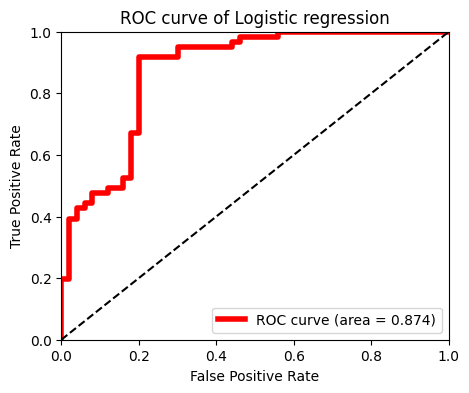

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

In [15]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[15 35]
 [ 0 61]]


In [16]:
data['y'].value_counts()

1    220
0    150
Name: y, dtype: int64

In [17]:
# 1:1 비율로 랜덤 샘플링을 수행
positive_random_idx = data[data['y']==1].sample(50, random_state=30).index.tolist()
negative_random_idx = data[data['y']==0].sample(50, random_state=30).index.tolist()

# 랜덤 데이터로 데이터셋을 나눔
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = data['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size = 0.3)
print(x_train.shape)
print(x_test.shape)

IndexError: index (371) out of range

Step 4 분석 : 중요 키워드 분석하기

[(2.0323981438060743, 2042), (1.7596531336582337, 1900), (0.9106608641123634, 745), (0.8299674436850345, 773), (0.7974396314695843, 763)]
[(-0.6568537404176263, 1351), (-0.708674882328621, 1638), (-1.3086755395237817, 1691), (-1.3327490513944502, 1011), (-1.7839782389942964, 987)]


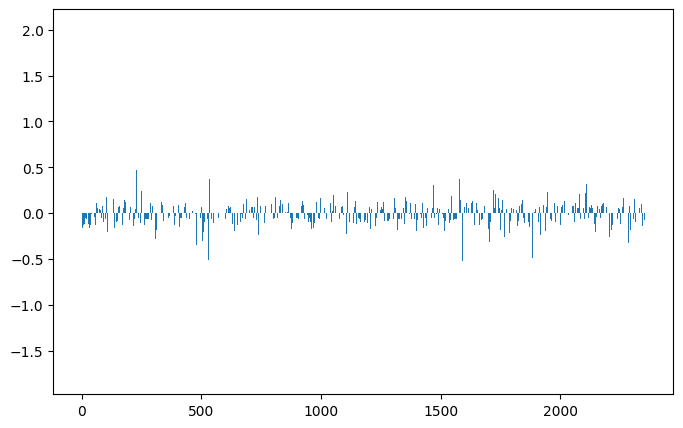

In [18]:
# 학습한 회귀 모델의 계수 출력
plt.rcParams['figure.figsize'] = [8, 5]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

In [19]:
# 회귀 모델의 계수를 높은 순으로 정렬
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

# 회귀 모델의 계수를 index_vectorizer에 맵핑하여 어떤 형태소인지 출력(value)
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로 피처에 형태소를 맵핑한 결과 출력
## 계수가 놓은 피처는 리뷰에 긍정적인 영향을 주는 형태소
print(str(invert_index_vectorizer)[:100] + '..')

{443: '녹는다/Verb', 444: '녹아/Verb', 1900: '좋아요/Adjective', 2346: '흠잡을/Adjective', 191: '곳/Noun', 1483:..


In [20]:
# 상위 20개 긍정 형태소
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

최고/Noun 2.0323981438060743
좋아요/Adjective 1.7596531336582337
맛있고/Adjective 0.9106608641123634
맛있음/Adjective 0.8299674436850345
맛있어요/Adjective 0.7974396314695843
비/Noun 0.5479047455220771
맛있게/Adjective 0.5306029737485679
존맛/Noun 0.5170240308106591
도/Josa 0.5076453270858414
가성/Noun 0.4974990570418733
곱/Noun 0.4957134719198253
좋은/Adjective 0.49192310463083944
구워주시고/Verb 0.47423293892726903
직원/Noun 0.46729543697590126
친절하고/Adjective 0.39451863586427377
곳/Noun 0.38964499007298026
좋습니다/Adjective 0.384192962589212
완전/Noun 0.3758686517308839
육즙/Noun 0.3754924978304234
과/Josa 0.3718308802129312


In [21]:
# 하위 20개 부정 형태소
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

턱/Noun -0.4068320509416504
못/VerbPrefix -0.4073996956683376
비추/Verb -0.40885497116020025
안/VerbPrefix -0.42076409678225624
무난/Noun -0.4280767171384877
불친절/Noun -0.435243013220932
볶음밥/Noun -0.4356938961725228
가/Josa -0.4429271354918767
에/Josa -0.4763844756840223
싼/Verb -0.4785350579404886
좀/Noun -0.4864748018812899
대비/Noun -0.5098330296758873
요/Josa -0.5178662901809958
을/Josa -0.5231425267287422
점/Noun -0.5315553901197066
아쉬워요/Adjective -0.6568537404176263
은/Josa -0.708674882328621
이에요/Josa -1.3086755395237817
보통/Noun -1.3327490513944502
별로/Noun -1.7839782389942964


In [22]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [23]:
# 상위 10개의 명사를 출력합니다.
noun_list[:10]

[('최고/Noun', 2.0323981438060743),
 ('비/Noun', 0.5479047455220771),
 ('존맛/Noun', 0.5170240308106591),
 ('가성/Noun', 0.4974990570418733),
 ('곱/Noun', 0.4957134719198253),
 ('직원/Noun', 0.46729543697590126),
 ('곳/Noun', 0.38964499007298026),
 ('완전/Noun', 0.3758686517308839),
 ('육즙/Noun', 0.3754924978304234),
 ('대창/Noun', 0.3712952249041264)]

In [24]:
# 상위 10개의 형용사를 출력합니다.
adjective_list[:10]

[('좋아요/Adjective', 1.7596531336582337),
 ('맛있고/Adjective', 0.9106608641123634),
 ('맛있음/Adjective', 0.8299674436850345),
 ('맛있어요/Adjective', 0.7974396314695843),
 ('맛있게/Adjective', 0.5306029737485679),
 ('좋은/Adjective', 0.49192310463083944),
 ('친절하고/Adjective', 0.39451863586427377),
 ('좋습니다/Adjective', 0.384192962589212),
 ('깔끔하고/Adjective', 0.36126418911547564),
 ('맛있는데/Adjective', 0.35693770791650054)]